<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цели-и-ход-исследования" data-toc-modified-id="Цели-и-ход-исследования-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цели и ход исследования</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Линейные-модели" data-toc-modified-id="Линейные-модели-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейные модели</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование потребления электроэнергии







## Цели и ход исследования

В данном исследовании мы проанализируем исторические данные о потреблении электроэнергии.

**Цель исследования**:
Построить модель, которая прогнозирует потребление на следующий день.

**Ход исследования**:
- Подготовка данных
- Анализ данных
- Обучение моделей
- Тестирование модели

## Подготовка

In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import optuna

import lightgbm as lgb

from catboost import CatBoostRegressor, Pool

from pymystem3 import Mystem

import re

import warnings; warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Открываем файл
try:
    df = pd.read_csv('train_dataset.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/content/drive/MyDrive/train_dataset.csv', index_col=[0], parse_dates=[0])

try:
    df_test = pd.read_csv('test_dataset.csv', index_col=[0], parse_dates=[0])
except:
    df_test = pd.read_csv('/content/drive/MyDrive/test_dataset.csv', index_col=[0], parse_dates=[0])

In [ ]:
# Изучим информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 to 2023-03-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          37224 non-null  int64  
 1   target        37224 non-null  float64
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 to 2023-07-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2928 non-null   int64  
 1   target        2928 non-null   float64
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB


In [ ]:
df.head()

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [ ]:
# Проверим расположены ли даты и время в хронологическом ли порядке
df.index.is_monotonic

True

In [ ]:
# Ресемплируем данные по одному часу
df_resapmle = df.drop(['time', 'temp', 'temp_pred', 'weather_pred', 'weather_fact'], axis=1)
df_resapmle =df_resapmle.resample('1D').sum()

In [ ]:
df_test_resapmle = df_test.drop(['time', 'temp', 'temp_pred', 'weather_pred', 'weather_fact'], axis=1)
df_test_resapmle =df_test_resapmle.resample('1D').sum()

In [ ]:
df_resapmle.head()

,target
date,
2019-01-01,11126.866
2019-01-02,11547.210
2019-01-03,12235.564
2019-01-04,12763.044
2019-01-05,12735.145


In [ ]:
df_temp = df[['temp', 'temp_pred']].resample('1D').mean()
df_test_temp = df_test[['temp', 'temp_pred']].resample('1D').mean()

In [ ]:
df_temp.head()

,temp,temp_pred
date,,
2019-01-01,4.8750,4.375
2019-01-02,1.3500,1.500
2019-01-03,-1.1625,-1.375
2019-01-04,-1.5000,-0.125
2019-01-05,0.9375,1.500


In [ ]:
df_weather = df[['weather_pred', 'weather_fact']].\
reset_index().\
groupby('date').\
agg(pd.Series.mode)

In [ ]:
df_weather.head()

,weather_pred,weather_fact
date,,
2019-01-01,"пасм, 80% дождь","ветер, пасм,дождь"
2019-01-02,"пасм, ветер, снег","пасм, ветер, снег, метель"
2019-01-03,"пасм, 24% дождь","ясно, ветер"
2019-01-04,"пасм, 16% дождь","пасм, ветер"
2019-01-05,"[пасм, 74% дождь,, снег, прояснения?]",пасмурно


In [ ]:
# напишем функцию для лемматизации текстов и очищения их от лишних знаков и пробелов

def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
    result = " ".join(re.sub(r'[^а-яА-ЯёЁ ]', ' ', text).split())
    return result

In [ ]:
# применим функцию к текстам
#weather_pred_lemmatized = df['weather_pred'].apply(lemmatize)
#weather_fact_lemmatized = df['weather_fact'].apply(lemmatize)

In [ ]:
#df_weather['weather_pred'] = weather_pred_lemmatized
#df_weather['weather_fact'] = weather_fact_lemmatized

In [ ]:
df_weather.head()

In [ ]:
df_weather.unique()

In [ ]:
df = df_resapmle.join(df_temp)
df_test = df_test_resapmle.join(df_test_temp)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551 entries, 2019-01-01 to 2023-03-31
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   target     1551 non-null   float64
 1   temp       1551 non-null   float64
 2   temp_pred  1551 non-null   float64
dtypes: float64(3)
memory usage: 80.8 KB


In [ ]:
df.head()

,target,temp,temp_pred
date,,,
2019-01-01,11126.866,4.8750,4.375
2019-01-02,11547.210,1.3500,1.500
2019-01-03,12235.564,-1.1625,-1.375
2019-01-04,12763.044,-1.5000,-0.125
2019-01-05,12735.145,0.9375,1.500


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2023-04-01 to 2023-07-31
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   target     122 non-null    float64
 1   temp       122 non-null    float64
 2   temp_pred  122 non-null    float64
dtypes: float64(3)
memory usage: 7.9 KB


In [ ]:
# Проверим на наличие пропусков
df.isna().sum()

target          0
temp            0
temp_pred       0
weather_pred    0
weather_fact    0
dtype: int64

## Анализ

In [ ]:
# Посмотрим, где начинается временнной ряд
df.index.min()

Timestamp('2019-01-01 00:00:00', freq='D')

In [ ]:
# и где заканчивается
df.index.max()

Timestamp('2023-03-31 00:00:00', freq='D')

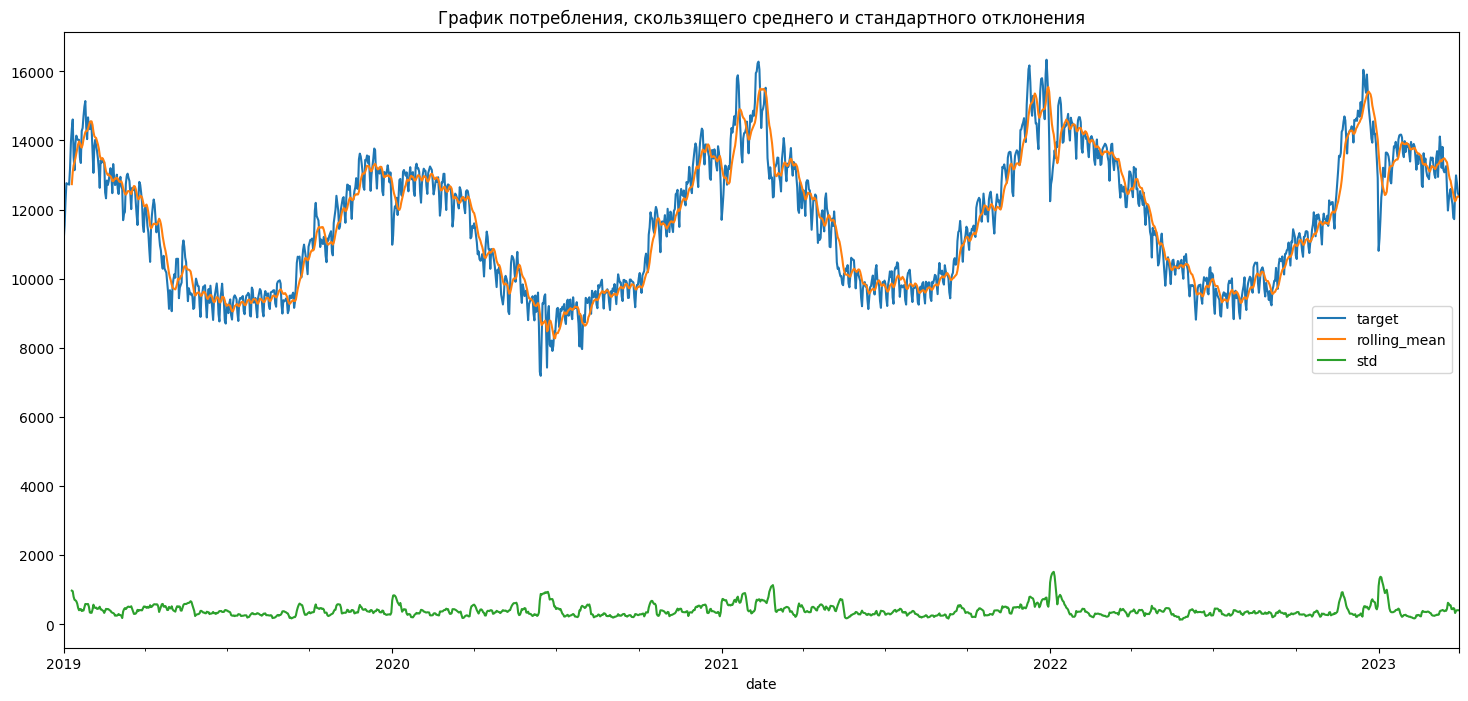

In [ ]:
from numpy.lib.function_base import delete
# Построим график заказов, скользящего среднего и стандартного отклонения
df_a = df.copy()
df_a['rolling_mean'] = df_a['target'].rolling(10).mean()
df_a['std'] = df_a['target'].rolling(10).std()
df_a[['target','rolling_mean', 'std']].plot(figsize = (18,8),
                                            title = 'График потребления, скользящего среднего и стандартного отклонения');
del df_a

**Перед нами нестационарный временной ряд, среднее значение и стандартное отклонение которого со временем меняются.**

In [ ]:
# Разложим временной ряд тренд, сезонность и остаток
decomposed = seasonal_decompose(df['target'])

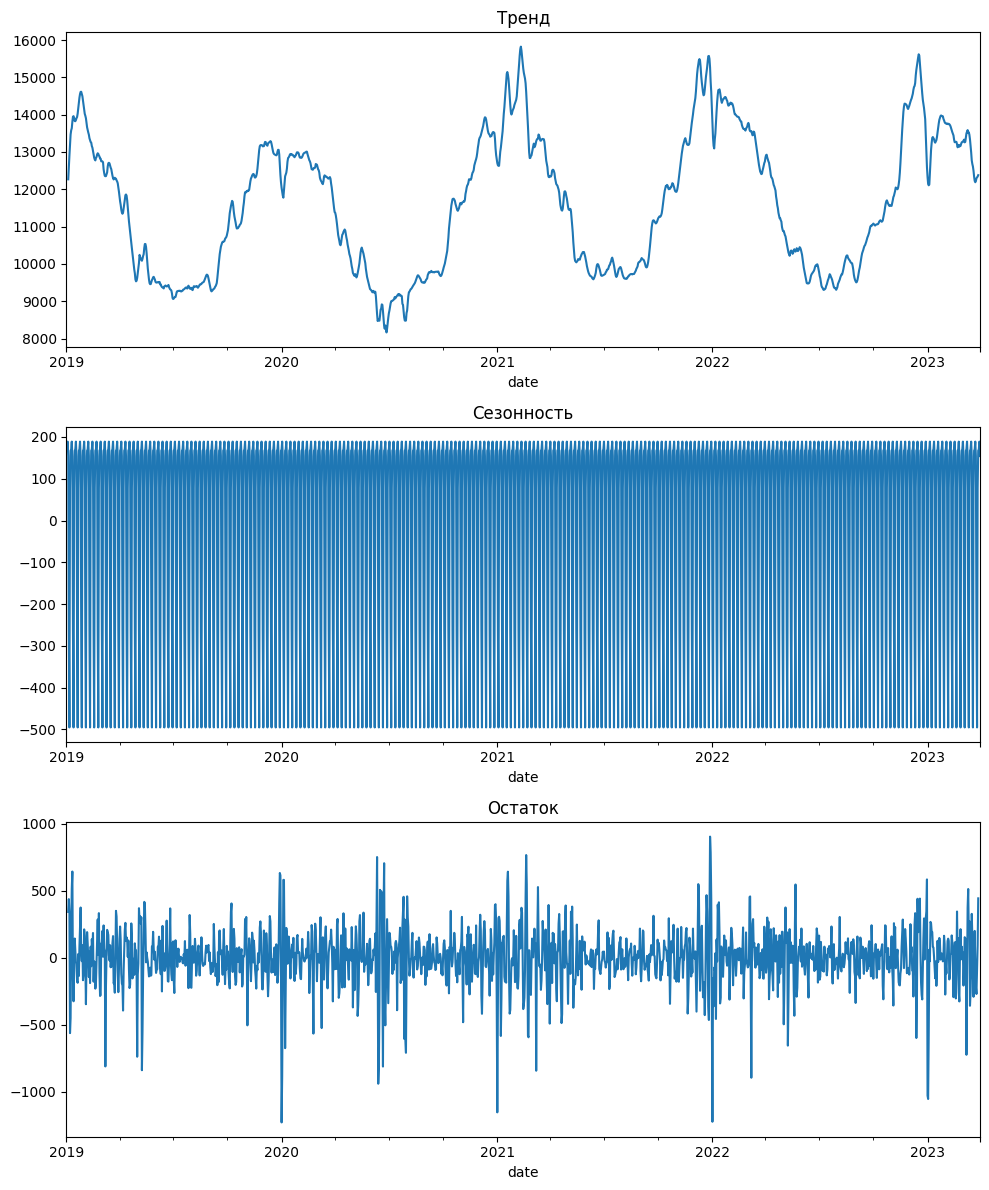

In [ ]:
# Построим графики трех компонентов

plt.figure(figsize=(10, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

plt.tight_layout()

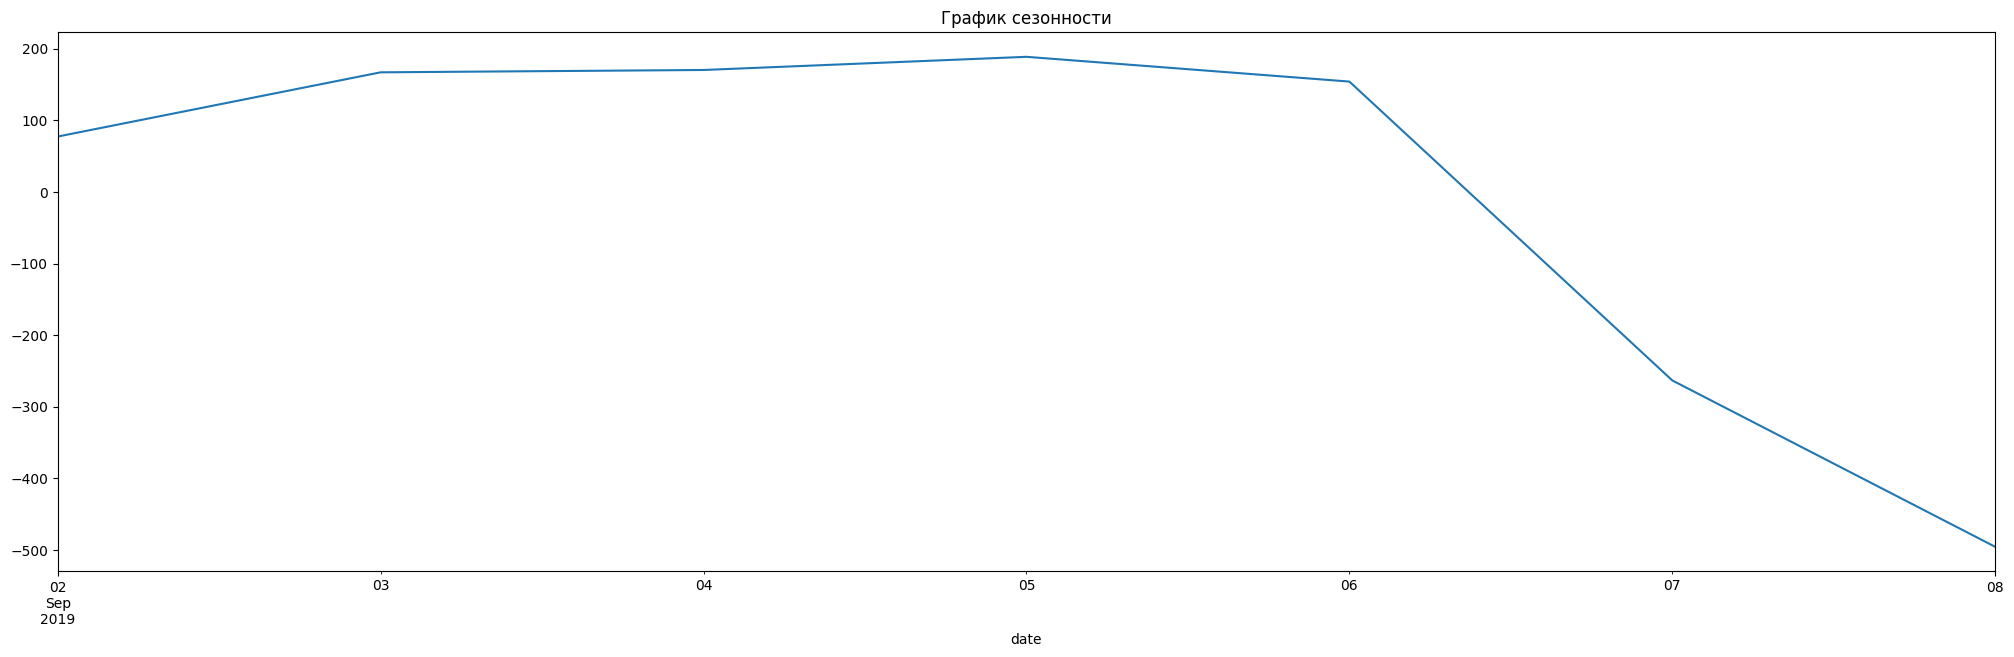

In [ ]:
# Исследуем сезонность на периоде в одину неделю с понедельника по воскресенье
decomposed.seasonal['2019-09-02 00:00:00':'2019-09-08 00:00:00'].plot(figsize = (25,7),
                                                                      title = 'График сезонности');

In [ ]:
del decomposed

## Обучение

### Подготовка признаков

In [ ]:
# Создадим признаки

df_train = df.copy()
df_train['day'] = df_train.index.dayofyear
df_train['dayofweek'] = df_train.index.dayofweek
df_train['month'] = df_train.index.month
df_train['quarter'] = df_train.index.quarter
df_train['lag_1'] = df_train['target'].shift(1)
df_train['lag_7'] = df_train['target'].shift(7)
df_train['lag_14'] = df_train['target'].shift(14)



In [ ]:
df_test = df_test.copy()
df_test['day'] = df_test.index.dayofyear
df_test['dayofweek'] = df_test.index.dayofweek
df_test['month'] = df_test.index.month
df_test['quarter'] = df_test.index.quarter
df_test['lag_1'] = df_test['target'].shift(1)
df_test['lag_7'] = df_test['target'].shift(7)
df_test['lag_14'] = df_test['target'].shift(14)



In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551 entries, 2019-01-01 to 2023-03-31
Freq: D
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            1551 non-null   float64
 1   temp              1551 non-null   float64
 2   temp_pred         1551 non-null   float64
 3   day               1551 non-null   int64  
 4   dayofweek         1551 non-null   int64  
 5   month             1551 non-null   int64  
 6   quarter           1551 non-null   int64  
 7   lag_1             1550 non-null   float64
 8   lag_7             1544 non-null   float64
 9   lag_14            1537 non-null   float64
 10  lag_365           1186 non-null   float64
 11  rolling_mean_30   1521 non-null   float64
 12  rolling_mean_365  1186 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 201.9 KB


In [ ]:
df_train.head()

,target,temp,temp_pred,day,dayofweek,month,quarter,lag_1,lag_7,lag_14
date,,,,,,,,,,
2019-01-01,11126.866,4.8750,4.375,1,1,1,1,NaN,NaN,NaN
2019-01-02,11547.210,1.3500,1.500,2,2,1,1,11126.866,NaN,NaN
2019-01-03,12235.564,-1.1625,-1.375,3,3,1,1,11547.210,NaN,NaN
2019-01-04,12763.044,-1.5000,-0.125,4,4,1,1,12235.564,NaN,NaN
2019-01-05,12735.145,0.9375,1.500,5,5,1,1,12763.044,NaN,NaN


In [ ]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [ ]:
df_train.shape

(1537, 10)

In [ ]:
df_test.shape

(108, 10)

In [ ]:
# Выделим признаки и целевой признак
features_train = df_train.drop(['target', 'temp'], axis = 1)
target_train =  df_train['target']

features_test = df_test.drop(['target', 'temp'], axis = 1)
target_test =  df_test['target']

In [ ]:
# Сохраним категориальные признаки в одну переменную
#cat_features = ['weather_pred','weather_fact']

In [ ]:
# Закодируем категориальные признаки с помощью OneHotEncoder
# и масштабируем числовые признаки с помощью StandardScaler, поместим оба действия в ColumnTransformer
#encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

### Линейные модели

In [ ]:
# Обучим модель ElasticNet, проверим качество модели на кросс-валидации с помощью cross_val_score
elastic = ElasticNet()

tscv = TimeSeriesSplit(n_splits=12)

param_grid = {'alpha':  np.linspace(0.1, 1.0, 10),
              'l1_ratio': np.linspace(0.1, 1.0, 10)}

el = GridSearchCV(elastic,
                  cv=tscv,
                  param_grid = param_grid,
                  scoring = 'neg_mean_absolute_error',
                  n_jobs = -1,
                  verbose = True)

el.fit(features_train, target_train)

Fitting 12 folds for each of 100 candidates, totalling 1200 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=12, test_size=None),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_absolute_error', verbose=True)

In [ ]:
el.best_params_

{'alpha': 0.7000000000000001, 'l1_ratio': 0.4}

In [ ]:
np.abs(el.best_score_)

247.7112486891524

### CatBoostRegressor

In [ ]:
# Обучим CatBoostRegressor с гиперпараметрами по умолчанию
cb = CatBoostRegressor(eval_metric= 'MAE', random_seed = 12345, verbose = False)

tscv = TimeSeriesSplit(12)

grid = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
        'depth': [2, 4, 6, 8, 10],
        'iterations': [1000, 1500, 2000]}

gs = cb.grid_search(grid, features_train, target_train, cv=tscv, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 218.7362109
bestIteration = 999


bestTest = 172.5337764
bestIteration = 999


bestTest = 161.0694848
bestIteration = 999


bestTest = 156.9710964
bestIteration = 998


bestTest = 158.5040398
bestIteration = 990


bestTest = 200.8968852
bestIteration = 1499


bestTest = 159.6391873
bestIteration = 1499


bestTest = 154.7797865
bestIteration = 1499


bestTest = 154.2719248
bestIteration = 1369


bestTest = 157.8764588
bestIteration = 1498


bestTest = 187.5856983
bestIteration = 1998


bestTest = 155.3362942
bestIteration = 1998


bestTest = 152.7231314
bestIteration = 1978


bestTest = 153.8473259
bestIteration = 1870


bestTest = 157.8764588
bestIteration = 1498


bestTest = 203.091166
bestIteration = 999


bestTest = 170.0860599
bestIteration = 997


bestTest = 162.5312423
bestIteration = 999


bestTest = 161.1436596
bestIteration = 985


bestTest = 161.941566
bestIteration = 641


bestTest = 182.2487979
bestIteration = 1499


bestTest = 162.3549297
bestIteration = 1499



In [ ]:
cb.get_best_score()

{'learn': {'MAE': 115.50327036952186, 'RMSE': 154.0104307055389}}

In [ ]:
cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 2,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'l

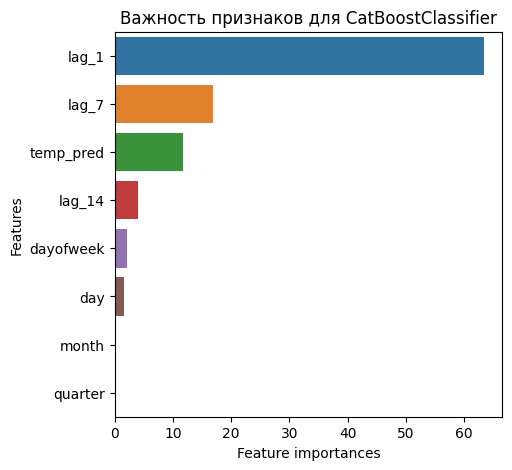

In [ ]:
# Посмотрим на важность признаков для CatBoostClassifier

cb_feat_imp = cb.get_feature_importance(prettified=True)

plt.subplots(figsize=(5, 5))
ax = sns.barplot(x=cb_feat_imp['Importances'], y=cb_feat_imp['Feature Id'])
ax.set_title('Важность признаков для CatBoostClassifier')
ax.set_yticklabels(cb_feat_imp['Feature Id'])
ax.set_xlabel('Feature importances')
ax.set_ylabel('Features')
plt.show()

In [ ]:
# Протестируем лучшую модель
predictions_test = cb.predict(features_test)
test_result = mean_absolute_error(target_test, predictions_test)

In [ ]:
test_result

143.03818360314804